In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice, seed
from numpy import sqrt
from scipy.stats import norm
import pandas as pd

In [3]:
symmetric_random_walk = lambda nsteps: np.cumsum(np.append(0, choice([-1,1], nsteps)))
scaled_random_walk  = lambda partitions, t: symmetric_random_walk(partitions * t) / sqrt(partitions)

## Payoff of a call option

In [4]:
X = np.linspace(0, 80, 25)
call = lambda s, k: max(s - k, 0)
Y = [call(x, 50) for x in X]

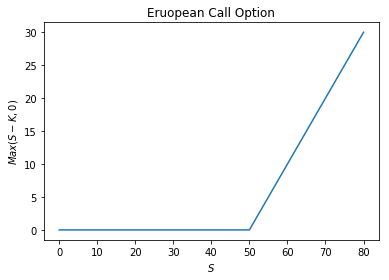

In [5]:
plt.plot(X, Y)
plt.ylabel(r"$Max(S - K, 0)$")
plt.xlabel(r"$S$")
plt.title("Eruopean Call Option")
plt.savefig("../images/Call.pdf")
plt.show()

## Symmetric Random Walk

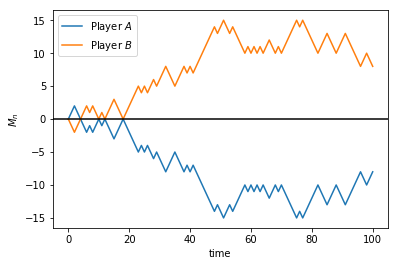

In [8]:
seed(1643)
rwalk_sample = symmetric_random_walk(100)
plt.plot(rwalk_sample, label="Player $A$")
plt.plot(-rwalk_sample, label="Player $B$")
plt.axhline(y=0, xmin=0, xmax=100, color="black")
plt.xlabel("time")
plt.ylabel("$M_n$")
plt.legend(loc="best")
plt.savefig("../images/symmetric_random_walk.pdf")
plt.show()

## Scaled Random Walk

In [9]:
seed(1643)

breaks = 1000
RW = pd.DataFrame()
partitions = [1, 10, 20, 500]

rw = scaled_random_walk(breaks, 1)
for partition in partitions:
    new_scale = int(breaks / partition)
    rw_new = scaled_random_walk(new_scale, 1)
    rw_new_rows = np.array([i * partition for i in range(new_scale + 1)])
    
    RW.ix[rw_new_rows, "N = {}".format(new_scale)] = rw_new
    
RW.index = np.linspace(0, 1, breaks + 1)
RW.ffill(inplace=True)

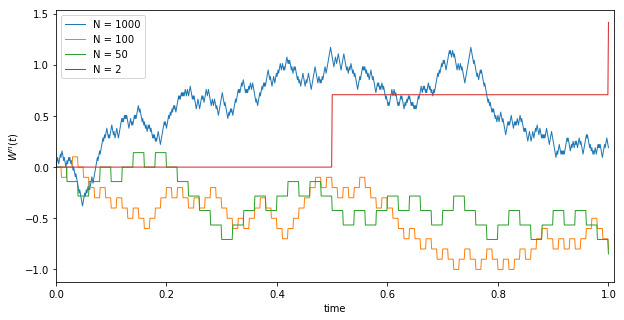

In [10]:
RW.plot(linewidth=1, figsize=(10,5))
plt.xlabel("time")
plt.ylabel("$W^n(t)$")
plt.xlim(0, 1.01);
plt.savefig("../images/scaled_random_walk.pdf")
plt.show()

## Distribution of a Symmetric random walk as n tends to infinity 

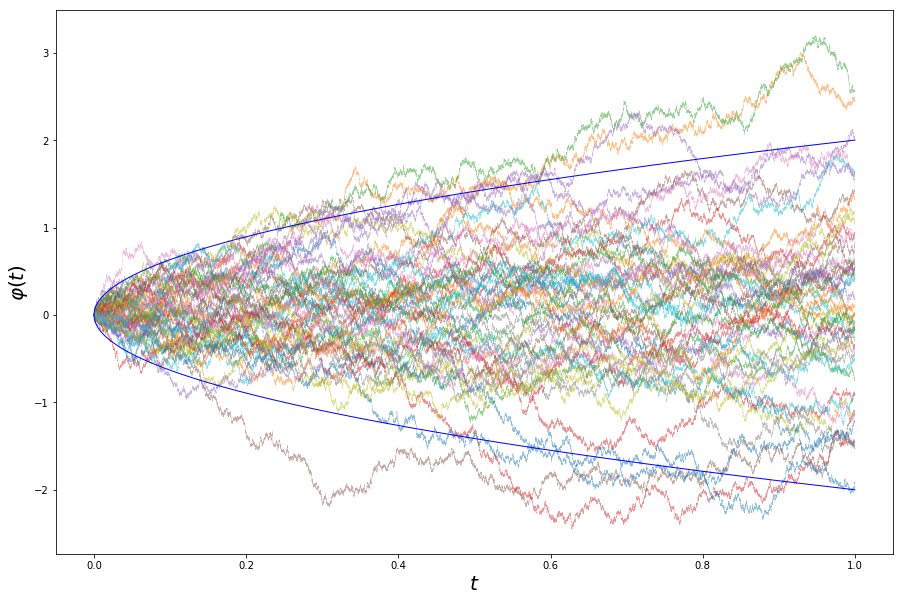

In [17]:
seed(1707)
partitions = 90000
plt.figure(figsize=(15,10))
for i in range(50):
    x = np.linspace(0, 1, partitions+1)
    wn = scaled_random_walk(partitions, 1)
    plt.plot(x, wn, linewidth=0.3, alpha=0.5)
    
plt.plot(x, 2*np.sqrt(x), color="blue", linewidth=1)
plt.plot(x, -2*np.sqrt(x), color="blue", linewidth=1)
plt.xlabel("$t$", fontsize=20)
plt.ylabel(r"$\varphi(t)$", fontsize=20)
plt.savefig("../images/bm.pdf")
plt.show()

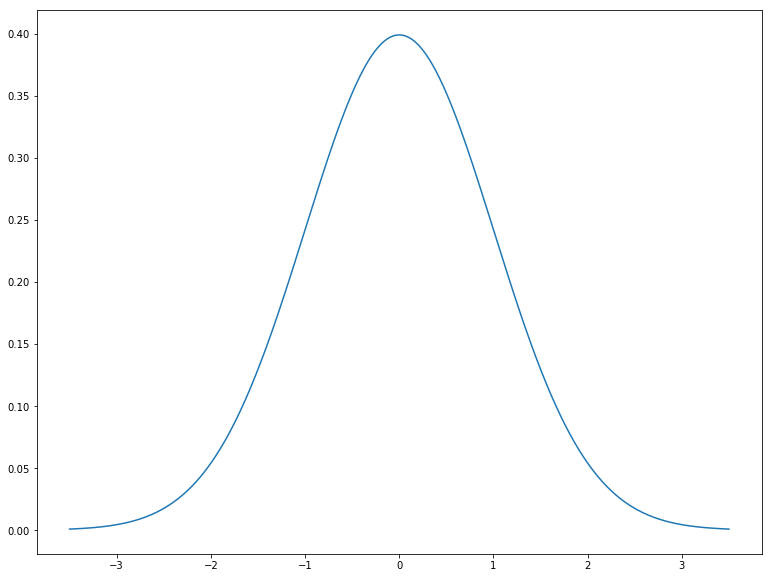

In [6]:
plt.figure(figsize=(13,10))
x = np.linspace(-3.5, 3.5, 500)
plt.plot(x, norm.pdf(x))
plt.savefig("../images/normal_distribution.pdf")
plt.show()